# 0 - Requirements

In [1]:
import torch
import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import copy
from model.ViT_model import ViT_model

In [2]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
__pyTorch VERSION: 1.9.1+cu102
__CUDA VERSION
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


# 1 - OCT dataset

In [3]:
# Parameters
device = 'cuda' if torch.cuda.is_available() else torch.device('cpu')
batch_size = 64
input_size = (192,192)
mean = [.456,.456,.456]
std = [.224,.224,.224]
num_classes = 4

In [4]:
# Load Dataset and Transform
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(input_size),
    torchvision.transforms.Normalize((mean), (std))
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(input_size),
    torchvision.transforms.Normalize((mean), (std))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.Normalize((mean), (std))
])

label_transform = torchvision.transforms.Lambda(lambda x: torch.nn.functional.one_hot(torch.as_tensor(x), num_classes = num_classes))

image_dataset = {
    'train': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\train", train_transform, label_transform),
    'val': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\val", val_transform, label_transform),
    'test': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\test", test_transform, label_transform)
}

data_loader = {
    x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size,
                                    shuffle=True)
    for x in ['train', 'val', 'test']
}

# Identifications
label2idx = {key:value for key,value in zip(image_dataset['train'].classes,range(num_classes))}
idx2label = {v:k for k,v in label2idx.items()}
dataset_sizes = {tag:len(data_loader[tag].dataset) for tag in ['train','val','test']}

Feature batch shape: torch.Size([64, 3, 192, 192])
Labels batch shape: torch.Size([64, 4])


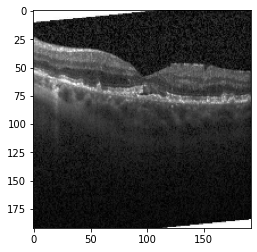

Label: CNV


In [5]:
# Display image and label.
train_features, train_labels = next(iter(data_loader['train']))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(((img.permute(1,2,0).numpy()*std+mean)*255).astype('uint8'), cmap="gray")
plt.show()
print(f"Label: {idx2label[torch.argmax(label).item()]}")

# 2 - Training pipeline

In [6]:
def train_model(model, criterion, optimizer, scheduler, device, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 3 - Train model 

In [8]:
model = ViT_model(depth = 2,
                  depth_te = 4,
                  linear_list = [4],
                  preprocessing = 'conv',
                  num_patches=16,
                  patch_size = 16,
                  num_channels = 3,
                  hidden_dim = 64,
                  num_heads = 8,
                  attn_drop = .2,
                  proj_drop = .2,
                  linear_drop = .2,
                  dtype = None,
                  )
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
lambda1 = lambda epoch: 0.75 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
print('Num. parameters:',sum(p.numel() for p in model.parameters()))

Architecture information:
Level 0:
	Patch size: 16
	Num. patches: 16
	Projection size: 768
	Hidden dim. size: 64
Level 1:
	Patch size: 8
	Num. patches: 64
	Projection size: 192
	Hidden dim. size: 32
Level 2:
	Patch size: 4
	Num. patches: 256
	Projection size: 48
	Hidden dim. size: 16
Num. parameters: 3168840


In [ ]:
train_model(model, criterion, optimizer, scheduler, device, num_epochs = 5)